### Word Embeddings

In [125]:
import smart_open
smart_open.open = smart_open.smart_open
from gensim.models import Word2Vec
import gensim
from gensim import utils
import pandas as pd
import numpy as np
from nltk import word_tokenize
from nltk import download
from nltk.corpus import stopwords

from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn import metrics
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB

import warnings
warnings.filterwarnings('ignore')

In [109]:
df = pd.read_csv('pre-processed.csv')

df['_class'] = df['label'].apply(lambda x: 0 if x == 'fake' else 1)

In [129]:
#svm = LinearSVC()
svm = SVC()
cc_svm = CalibratedClassifierCV(svm)
rfc = RandomForestClassifier()
bnb = BernoulliNB()

In [111]:
from gensim.models import KeyedVectors

# Load word2vec model (trained on an enormous Google corpus)
model = KeyedVectors.load_word2vec_format('D:\python\model_npl\GoogleNews-vectors-negative300.bin', binary = True) 

# Check dimension of word vectors
model.vector_size

300

In [112]:
def preprocess(text):    
    doc = word_tokenize(text)    
    return doc

In [113]:
texts, y = df.preprocessed_news, df._class

corpus = [preprocess(text) for text in texts]

In [114]:
def filter_docs(corpus, texts, labels, condition_on_doc):
    """
    Filter corpus, texts and labels given the function condition_on_doc which takes a doc.
    The document doc is kept if condition_on_doc(doc) is true.
    """
    number_of_docs = len(corpus)

    if texts is not None:
        texts = [text for (text, doc) in zip(texts, corpus)
                 if condition_on_doc(doc)]

    labels = [i for (i, doc) in zip(labels, corpus) if condition_on_doc(doc)]
    corpus = [doc for doc in corpus if condition_on_doc(doc)]

    print("{} docs removed".format(number_of_docs - len(corpus)))

    return (corpus, texts, labels)

In [115]:
def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in word2vec_model.vocab]
    return np.mean(word2vec_model[doc], axis=0)

In [116]:
def has_vector_representation(word2vec_model, doc):
    """check if at least one word of the document is in the
    word2vec dictionary"""
    return not all(word not in word2vec_model.vocab for word in doc)

In [117]:
corpus, texts, y = filter_docs(corpus, texts, y, lambda doc: has_vector_representation(model, doc))

0 docs removed


In [118]:
x =[]
for doc in corpus: #look up each doc in model
    x.append(document_vector(model, doc))

In [119]:
X = np.array(x) #list to array

In [120]:
X.shape, len(y)

((7200, 300), 7200)

In [121]:
X[1]

array([-0.05375732,  0.0350647 ,  0.09158813,  0.0897963 , -0.02258179,
        0.04398438, -0.03024719, -0.05777527, -0.01425659,  0.04950058,
       -0.11113159, -0.11878601, -0.17565429,  0.0998291 , -0.09619126,
        0.12976807,  0.14143342,  0.1815564 , -0.01611511,  0.00245239,
       -0.04223633, -0.0683606 ,  0.18025391,  0.05656311, -0.11236939,
       -0.11269165, -0.10636353,  0.02334473, -0.10487793, -0.02198635,
       -0.02290375,  0.0985022 ,  0.03503113, -0.0831089 , -0.10985108,
       -0.03309936, -0.02096008,  0.10402161,  0.12792602, -0.06206585,
        0.01161255, -0.04094517,  0.15582214,  0.11641113,  0.01446106,
       -0.1347821 , -0.11189957, -0.09944824, -0.07104614,  0.1278064 ,
       -0.17889465,  0.14919311,  0.089552  ,  0.01955139, -0.09313591,
        0.15645751, -0.11686401, -0.103237  ,  0.06145874, -0.08716229,
       -0.10489449,  0.12127441, -0.02395813,  0.00849731,  0.04660927,
       -0.15836243, -0.01707489, -0.09016235, -0.0208139 ,  0.13

In [122]:
#separando dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [123]:
def exibeResultados(clf1,clf2):    
    
    clf1.fit(X_train, y_train)
    clf2.fit(X_train, y_train)

    preds = clf1.predict(X_test)

    y_proba = clf2.predict_proba(X_test)[:,1]
    
    print('-' * 80)
    print("{} Performance:".format(clf1))
    print('-' * 80)
    
    print('Accuracy:', metrics.accuracy_score(preds, y_test), '\n')    
    
    print(classification_report(y_test, preds), '\n')

    fpr, tpr, thresholds = roc_curve(y_test, y_proba)

    auc = metrics.roc_auc_score(y_test, y_proba)

    plt.figure(figsize = (12,8))
    plt.plot(fpr, tpr, color='orange', label='ROC Curve (UAC = ' + str(auc.round(6)) + ')')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('Taxa de Falsos Positivos (1 - Especificidade)')
    plt.ylabel('Taxa de Verdadeiros Positivos - Sensibilidade')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc=4)
    plt.show()

    print(pd.crosstab(np.array(y_test), np.array(preds), rownames=['Real'], colnames=['Predito'], margins=True), '\n')    

--------------------------------------------------------------------------------
SVC() Performance:
--------------------------------------------------------------------------------
Accuracy: 0.8796296296296297 

              precision    recall  f1-score   support

           0       0.92      0.83      0.87      1087
           1       0.84      0.93      0.88      1073

    accuracy                           0.88      2160
   macro avg       0.88      0.88      0.88      2160
weighted avg       0.88      0.88      0.88      2160
 



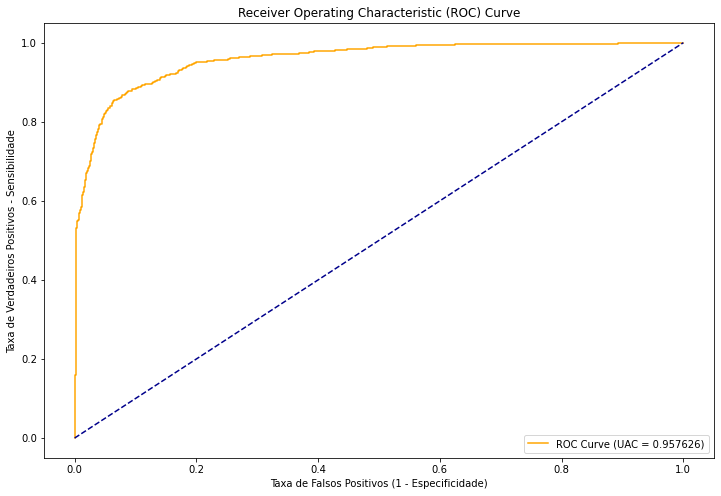

Predito    0     1   All
Real                    
0        903   184  1087
1         76   997  1073
All      979  1181  2160 

--------------------------------------------------------------------------------
RandomForestClassifier() Performance:
--------------------------------------------------------------------------------
Accuracy: 0.8870370370370371 

              precision    recall  f1-score   support

           0       0.86      0.93      0.89      1087
           1       0.92      0.85      0.88      1073

    accuracy                           0.89      2160
   macro avg       0.89      0.89      0.89      2160
weighted avg       0.89      0.89      0.89      2160
 



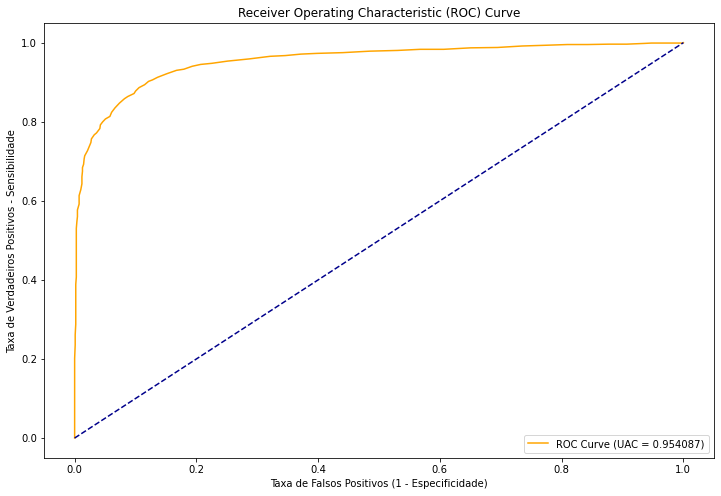

Predito     0    1   All
Real                    
0        1007   80  1087
1         164  909  1073
All      1171  989  2160 

--------------------------------------------------------------------------------
BernoulliNB() Performance:
--------------------------------------------------------------------------------
Accuracy: 0.8087962962962963 

              precision    recall  f1-score   support

           0       0.89      0.71      0.79      1087
           1       0.76      0.91      0.83      1073

    accuracy                           0.81      2160
   macro avg       0.82      0.81      0.81      2160
weighted avg       0.82      0.81      0.81      2160
 



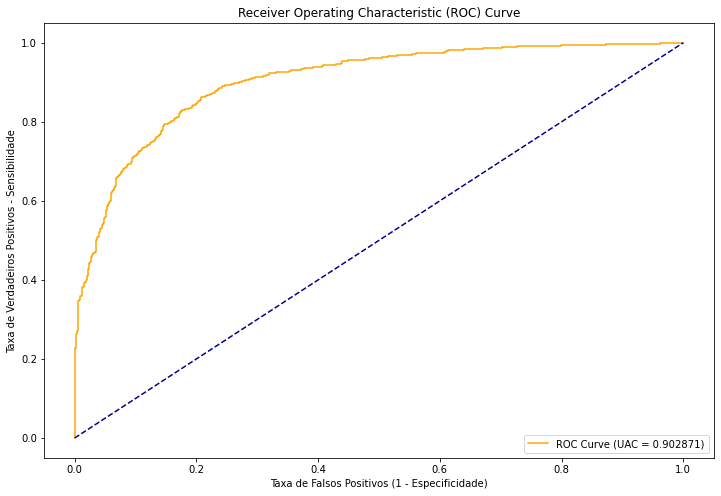

Predito    0     1   All
Real                    
0        772   315  1087
1         98   975  1073
All      870  1290  2160 



In [130]:
for clf1,clf2 in zip([svm,rfc,bnb],[cc_svm,rfc,bnb]):
    exibeResultados(clf1,clf2)